# Homework Principal Components Analysis

**Giorgia delle Grazie, s300879**

 **Computational Linear Algebra for Large Scale Problems, Politecnico di Torino**


The objective of this undertaking is to employ Principal Component Analysis (PCA) for the purpose of diminishing the complexity of a motorcycle dataset meant for a hackathon competition. The subsequent step involves the utilization of the k-Means algorithm to categorize motorcycles into significant clusters based on their inherent patterns.

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
import random

The project consist in work with a dataset of motorcycles described by many technical features:

• The data file consists of 38 472 rows and 27 columns;

• The data file contains both numeric and categorical data;

• The data file contains missing values for both categorical and  numeric features.

In [2]:
#import dataset
df_tot = pd.read_csv('cla4lsp22_bikez_curated.csv')
#print dataset
#display(df_tot)
#compute number of missingvalues
missing = df_tot.isnull().sum()

In [3]:
#Preparation (Setting the Random State):
rs = 300879
np.random.seed(rs)
#select a random integer r among 0, 1, 2
r = np.random.randint(0,3)
#create a sub-DFs workdf, extracted from df_tot
#select the row that contains only data 
#corresponding to years with reminder r,
#if divided by three
workdf = df_tot[df_tot.Year%3 == r]
#resets the index of workdf
workdf = workdf.reset_index(drop=True)

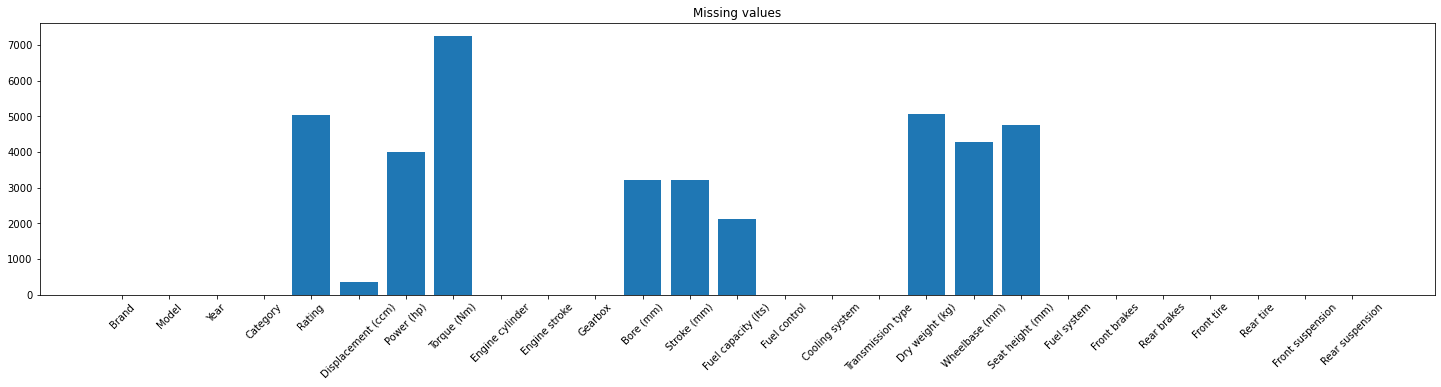

In [5]:
#compute the missign values of workdf
missing_values=workdf.isnull().sum()
#plot the missing values of workdf 
plt.figure(figsize=(25,5)) 
plt.bar(workdf.columns, missing_values) 
plt.xticks(rotation=45)
plt.title('Missing values')
plt.show()

In [6]:
#create features and labels
labels = ['Brand', 'Model', 'Year', 'Category', 'Rating']
features = workdf.columns.drop(labels).tolist()
#feature to drop
features_drop = ["Front brakes", "Front tire", "Front suspension","Rear brakes",\
                 "Rear tire", "Rear suspension"]
#Remove randomly from workdf two columns selected among the features
print('The removed fetaures are:')
for i in range(2):
    rand = np.random.randint(0, 6 - i)
    removed_feature = features_drop[rand]
    print('{}'.format(removed_feature))
    workdf = workdf.drop(columns=removed_feature)
    features.remove(removed_feature)
    features_drop.pop(rand)

The removed fetaures are:
Rear tire
Front suspension


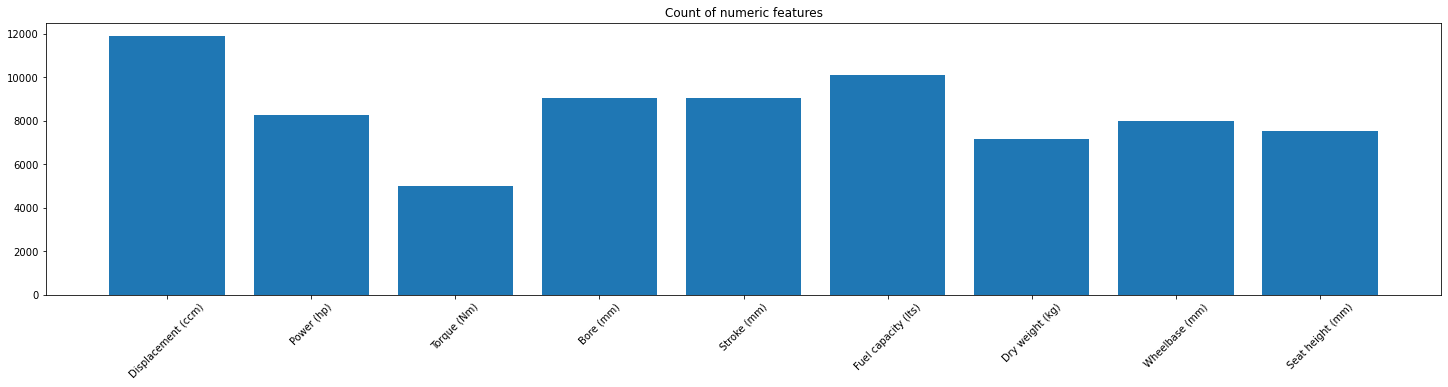

In [7]:
#plot the distribution of numeric features
plt.figure(figsize=(25,5)) 
plt.bar(workdf[features].select_dtypes(include=['float64']).columns,\
        workdf[features].select_dtypes(include=['float64']).count()) 
plt.xticks(rotation=45)
plt.title('Count of numeric features')
plt.show()

During the process of filling the  missing values in a dataset, various common strategies are employed:

**-Deletion of Rows or Columns**: This approach involves removing rows or columns containing missing values. However, this strategy could lead to the loss of valuable data, especially if the amount of missing data is huge. Therefore, it's necessary to carefully evaluate whether this option is suitable for the specific situation.

**-Computing the Mean**: Another common method is to replace missing values with the mean of the corresponding variable. This approach is particularly effective when the data follows an approximately normal distribution and is not significantly influenced by outlier values. However, it should be noted that the mean is sensitive to outliers and can be distorted by anomalous values.

**-Computing the Median**: Similar to the mean method, the median can be used to fill in missing values. Using the median to fill missing values is often a preferred choice. It offers several reasons:

Firstly, the median is more robust against the presence of outlier values compared to the mean, contributing to maintaining greater stability in the dataset.

Furthermore, the median is particularly recommended when data distributions are not symmetrical or approximately normal. Employing the median helps preserve the original distribution of the data, especially in cases of skewed or irregularly distributed data.

In this specific situation, where the dataset exhibits an asymmetric nature and and there are a large number of missing values,  an appropriate  decision is to use the median to fill missing values.

In [8]:
# Clean the dataset workdf from missing values in the numeric feature columns

#compute the number of missing value of numerical features
missing_value_numerical_feature = workdf[features].select_dtypes(include=['float64']\
                                                                ).isnull().sum()
#Calculates the median values of numerical features of workdf
median_c =  workdf[features].select_dtypes(include=['float64']).median()
#fills the missing values using the median values 
workdf = workdf.fillna(median_c)

**Encoding of Categorical Data**

In [9]:
#select only catecorical features
categoric_features = pd.DataFrame(workdf[features].select_dtypes("object"))
#columns of categorical features
cat_fea_col = categoric_features.columns
#columns of numerical features
numeric_features = workdf[features].select_dtypes(include=['float64']).columns
#number of rows in the categorical features DataFrame
num = categoric_features.shape[0]
#create an empty dataset
initial_data = pd.DataFrame(index = range(num))

In [10]:
#select the categorical columns where at least one cell contains a period
#character ('.')
point = []
for col in cat_fea_col:
    contains_sep = any("." in cell for cell in categoric_features[col])
    point.append(contains_sep)
point_columns = categoric_features.columns[point].tolist()

In [11]:
for col in cat_fea_col:
    #check if the columns of categorical data are in the list with columns which cells
    #contain the separetor '.'
    if col in point_columns:
        #dummy encoding considering the separetor '.'
        dumm = categoric_features[col].str.get_dummies(sep = ".")
    else:
         #standard dummy encoding
        dumm = categoric_features[col].str.get_dummies()
    # Rename the dummy-encoded columns with the original column name
    dumm = dumm.rename(columns = lambda tcol: col + " - " + tcol)
    # fill the empty dataset with the encoding values 
    initial_data = initial_data.join(dumm)
# Create a dataset for numerical features
feat = pd.DataFrame(workdf[numeric_features])
# Combine numerical and dummy-encoded categorical features into Xworkdf 
Xworkdf = feat.join(initial_data)
display(Xworkdf)

,Displacement (ccm),Power (hp),Torque (Nm),Bore (mm),Stroke (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm),Engine cylinder - Diesel,...,Front tire - other,Rear suspension - other,Rear suspension - dual shocks,"Rear suspension - link type, coil spring, oil damped",Rear suspension - monoshock,Rear suspension - not given/unknown,Rear suspension - other,Rear suspension - single shock,Rear suspension - swing arm,Rear suspension - twin shocks
0,349.7,804.0,56.3,72.5,61.2,13.5,420.0,1422.5,790.0,0,...,1,0,0,0,0,1,0,0,0,0
1,349.7,536.0,56.3,72.5,61.2,13.5,420.0,1422.5,790.0,0,...,1,0,0,0,0,1,0,0,0,0
2,608.0,45.6,56.3,72.5,61.2,21.0,342.0,1422.5,790.0,0,...,1,0,0,0,0,1,0,0,0,0
3,781.0,57.7,56.3,72.5,61.2,21.0,342.0,1422.5,790.0,0,...,0,0,0,0,0,0,1,0,0,0
4,781.0,57.7,56.3,72.5,61.2,21.0,358.0,1422.5,790.0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12261,49.0,27.0,56.3,39.0,42.0,13.5,142.0,1422.5,790.0,0,...,1,0,0,0,0,1,0,0,0,0
12262,211.0,2.8,56.3,62.0,70.0,6.0,73.0,1422.5,790.0,0,...,1,0,0,0,0,0,1,0,0,0
12263,211.0,2.3,56.3,62.0,70.0,6.0,58.0,1422.5,790.0,0,...,1,0,0,0,0,0,1,0,0,0
12264,211.0,2.3,56.3,62.0,70.0,6.0,142.0,1422.5,790.0,0,...,1,0,0,0,0,0,1,0,0,0


# Preprocessing and PCA

In [14]:
# Initialize a StandardScaler instance
scaler = StandardScaler()
# Apply standard scaling to Xworkdf and create a standardized dataset
Xworkdf_std = pd.DataFrame(scaler.fit_transform(Xworkdf),
                           columns=Xworkdf.columns)
# Initialize a MinMaxScaler instance
min_max = MinMaxScaler()
# Apply min-max scaling to Xworkdf and create a scaled dataset
Xworkdf_mm = pd.DataFrame(min_max.fit_transform(Xworkdf), 
                          columns=Xworkdf.columns)

# Calculate the variances of original numerical features
Xworkdf_var = Xworkdf[numeric_features].var(axis=0)
Xworkdf_var.name = "Original Variance"

# Calculate the variances of standardized numerical features
Xworkdf_std_var = Xworkdf_std[numeric_features].var(axis=0)
Xworkdf_std_var.name = "Standardized Variance"

# Calculate the variances of min-max scaled numerical features
Xworkdf_mm_var = Xworkdf_mm[numeric_features].var(axis=0)
Xworkdf_mm_var.name = "MinMax Variace"

# Display a comparison of original, standardized, and min-max scaled variances
display(pd.concat([Xworkdf_var, Xworkdf_std_var, Xworkdf_mm_var],\
                  axis=1))


,Original Variance,Standardized Variance,MinMax Variace
Displacement (ccm),290218.278680,1.000082,0.004343
Power (hp),1946.219273,1.000082,0.003013
Torque (Nm),1692.430504,1.000082,0.003373
Bore (mm),253.668985,1.000082,0.008283
Stroke (mm),237.072440,1.000082,0.009742
Fuel capacity (lts),29.695828,1.000082,0.007286
Dry weight (kg),4234.945478,1.000082,0.007246
Wheelbase (mm),18582.256504,1.000082,0.002842
Seat height (mm),4447.224575,1.000082,0.009848


**-Original variance**: This column represents the variance of each respective feature in their original units. For instance, the "Displacement (ccm)" feature has a variance of approximately 290218, indicating the extent of dispersion in motorcycle displacement values, since the vehicles in the dataset can have significantly different displacements, this values of  deviate considerably from the mean, resulting in a higher variance. 
Regarding the "Dry weight," we notice a relatively modest variance. This is because the dry weight signifies the motorcycle's weight without any fuel, oil, or additional fluids, aiming to maintain a similar dry weight contributes to enhanced consistency in both performance and maneuverability.

**-Standardized variance**: In this column, the variances of the features are computed after applying the StandardScaler transformation. The values are all close to 1 due to standardization, which centers the data around the mean with a standard deviation of 1.

**-MinMax variance**: This column contains the variances of the features after applying Min-Max scaling, where values are constrained within the range of 0 to 1. The values remain close to 1 due to the scaling process.

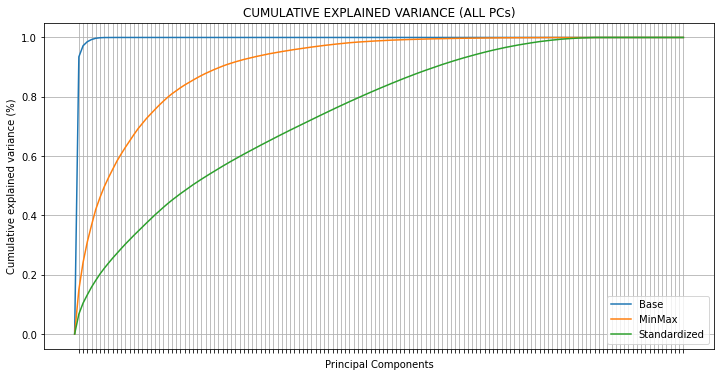

In [15]:
# Initialize Principal Component Analyses (PCAs) and Fit

# Initialize and fit PCA using original data
pca_base = PCA(random_state=rs)
pca_base.fit(Xworkdf)

# Initialize and fit PCA using standardized data
pca_std = PCA(random_state=rs)
pca_std.fit(Xworkdf_std)

# Initialize and fit PCA using min-max scaled data
pca_mm = PCA(random_state=rs)
pca_mm.fit(Xworkdf_mm)

# Create Cumulative Explained Variance Plot

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Calculate cumulative explained variance ratios for each PCA
cumvar_base = np.cumsum(pca_base.explained_variance_ratio_)
cumvar_mm = np.cumsum(pca_mm.explained_variance_ratio_)
cumvar_std = np.cumsum(pca_std.explained_variance_ratio_)

# Plot the cumulative explained variance for each PCA
plt.plot(np.insert(cumvar_base, 0, 0), label="Base")
plt.plot(np.insert(cumvar_mm, 0, 0), label="MinMax")
plt.plot(np.insert(cumvar_std, 0, 0), label="Standardized")

# Add legend and plot title
plt.legend()
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(1, pca_base.n_features_ + 1), labels=[])

# Add x and y axis labels
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')

# Add grid lines
plt.grid()

# Display the plot
plt.show()


The results of PCA on the original data demonstrate that a single principal component is enough to capture most of the explained variance of the dataset. This is because, as revealed by the previous analysis, the variances of the features exhibit different orders of magnitude in the various numeric features. On the other hand, with the scaled dataset, a greater number of principal components is required to achieve a proper explanation of the variance.


Subsequently, the minimum number of principal components required to achieve 35% of the explained variance is evaluated in all three cases.

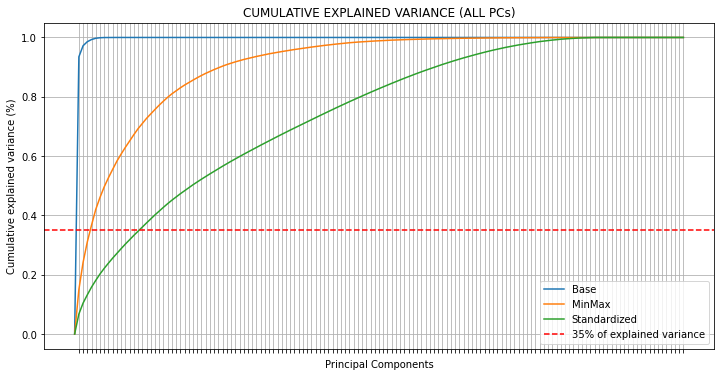

In [16]:
# Create a plot to visualize cumulative explained variance and threshold
plt.figure(figsize=(12, 6))

# Calculate cumulative explained variance ratios for each PCA
cumvar_base = np.cumsum(pca_base.explained_variance_ratio_)
cumvar_mm = np.cumsum(pca_mm.explained_variance_ratio_)
cumvar_std = np.cumsum(pca_std.explained_variance_ratio_)

# Plot cumulative explained variance for each scaling method
plt.plot(np.insert(cumvar_base, 0, 0), label="Base")
plt.plot(np.insert(cumvar_mm, 0, 0), label="MinMax")
plt.plot(np.insert(cumvar_std, 0, 0), label="Standardized")

# Add a red dashed line to indicate the 35% explained variance threshold
plt.axhline(y=0.35, color='red', linestyle='--', label="35% of explained variance")

# Add legend and plot title
plt.legend()
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(1, pca_base.n_features_ + 1), labels=[])

# Add x and y axis labels
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')

# Add grid lines
plt.grid()

# Display the plot
plt.show()

# Dimensionality reduction and Interpretation of the PCs

 This study aims to find important patterns among vehicles and keep at least 35% of the important information while using no more than 5 main components.

In [17]:
# Calculate the minimum number of principal components to reach 
#35% explained variance using MinMax scaling
m_1_mm = np.argmax(cumvar_mm > 0.35) + 1 

# Limit the count of principal components to a maximum of 
#5 for visualization purposes
m_mm = min(m_1_mm, 5)

# Calculate the minimum number of principal components to reach 
#35% explained variance using Standardized scaling
m_1_std = np.argmax(cumvar_std > 0.35) + 1

# Limit the count of principal components to a maximum 
#of 5 for visualization purposes
m_std = min(m_1_std, 5)

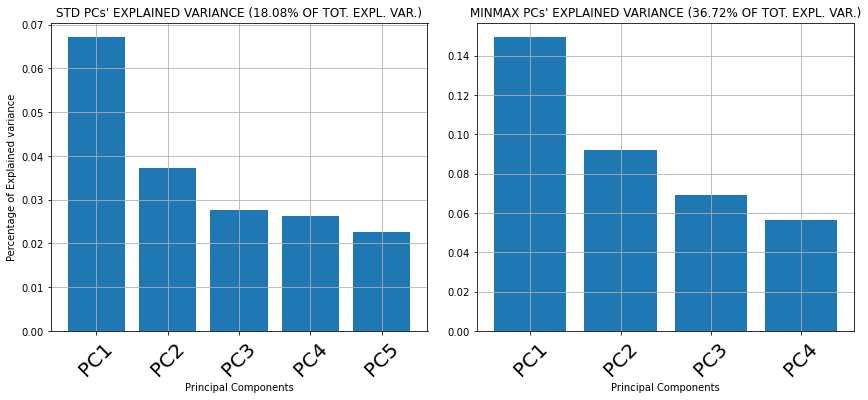

In [37]:
# Initialize and fit PCA using Standardized scaling and
#the determined number of principal components (m_std)
pca_std = PCA(random_state=rs, n_components=m_std)
pca_std.fit(Xworkdf_std)

# Initialize and fit PCA using MinMax scaling and the 
#determined number of principal components (m_mm)
pca_mm = PCA(random_state=rs, n_components=m_mm)
pca_mm.fit(Xworkdf_mm)

# Compute the percentage of total explained variance,
#rounded to 2 decimal places, for Standardized scaling
round_expl_var_ratio_std = np.round(pca_std.explained_variance_ratio_.\
                                    sum() * 100, decimals=2)

# Create a bar plot to visualize explained variance for Standardized scaling
fig, (ax_std, ax_mm) = plt.subplots(1, 2, figsize=(12, 5))
plt.tight_layout()

# Create the bar plot for Standardized scaling
ax_std.bar(range(1, m_std + 1), pca_std.explained_variance_ratio_)
ax_std.set_title\
(f"STD PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_std}% OF TOT. EXPL. VAR.)",\
                 fontsize=12)
ax_std.set_xticks(ticks=np.arange(1, m_std + 1), \
                  labels=[f'PC{i}'\
                    for i in range(1, m_std + 1)], rotation=45)
ax_std.set_xlabel('Principal Components')
ax_std.set_ylabel('Percentage of Explained variance')
ax_std.grid()

# Compute the percentage of total explained variance, 
#rounded to 2 decimal places, for MinMax scaling
round_expl_var_ratio_mm = \
np.round(pca_mm.explained_variance_ratio_.sum() * 100, decimals=2)

# Create a bar plot to visualize explained variance for MinMax scaling
ax_mm.bar(range(1, m_mm + 1), pca_mm.explained_variance_ratio_)
ax_mm.set_title\
(f"MINMAX PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_mm}% OF TOT. EXPL. VAR.)",\
                fontsize=12)
ax_mm.set_xticks\
(ticks=np.arange(1, m_mm + 1),\
 labels=[f'PC{i}' for i in range(1, m_mm + 1)], rotation=45)
ax_mm.set_xlabel('Principal Components')
ax_mm.grid()


For each PC in the Xworkdf_std dataset,  the name of the features with greatest contribute w.r.t. to the threshold  𝜖=√1/𝑛
  where 𝑛
  is the number of features are preanted.

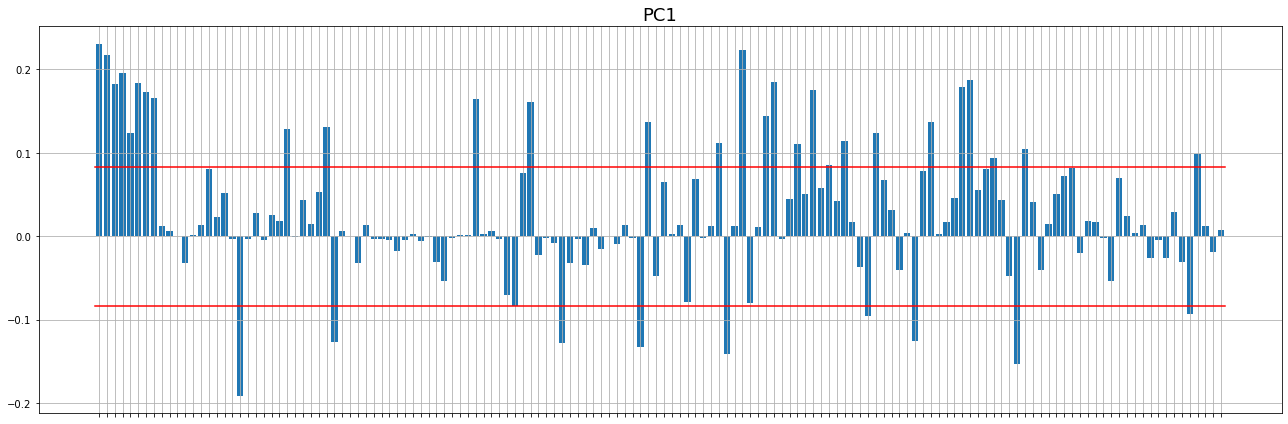


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Displacement (ccm)', 'Power (hp)', 'Torque (Nm)', 'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)', 'Dry weight (kg)', 'Wheelbase (mm)', 'Engine cylinder - V2', 'Engine stroke -  four-stroke', 'Gearbox - 6-speed', 'Fuel control - Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system - Liquid', 'Fuel system -  other', 'Fuel system - injection', 'Front brakes -  abs', 'Front brakes -  double disc', 'Front brakes -  four-piston calipers', 'Front brakes -  other', 'Front brakes - abs', 'Front brakes - double disc', 'Front brakes - floating discs', 'Rear brakes -  abs', 'Rear brakes -  other', 'Rear brakes -  single disc', 'Rear brakes - abs', 'Rear brakes - floating disc', 'Rear suspension - other']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder - Single cylinder', 'Engine stroke -  two-stroke', 'Gearbox - Not Given/Unknown', 'Fuel control - Not Given/Unknown', 'Cooling system - Air', 'Fuel system - ca

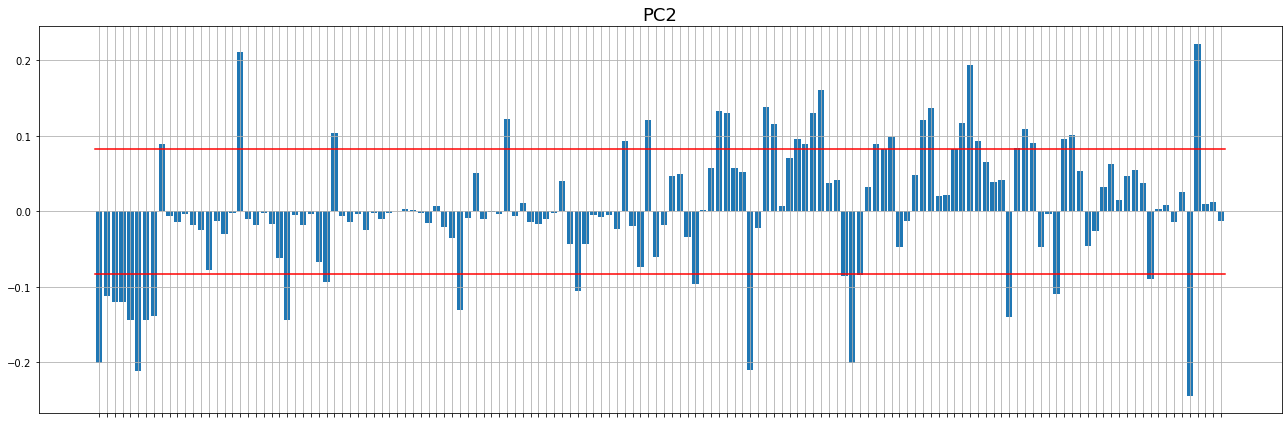


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Seat height (mm)', 'Engine cylinder - Single cylinder', 'Engine stroke -  two-stroke', 'Gearbox - Automatic', 'Fuel control - Single Overhead Cams (SOHC)', 'Cooling system - Liquid', 'Fuel system -  other', 'Fuel system - carburettor', 'Front brakes -  abs', 'Front brakes -  double disc', 'Front brakes -  four-piston calipers', 'Front brakes -  hydraulic', 'Front brakes -  other', 'Front brakes -  single disc', 'Front brakes - floating discs', 'Front brakes - hydraulic', 'Front brakes - two-piston calipers', 'Rear brakes -  abs', 'Rear brakes -  hydraulic', 'Rear brakes -  other', 'Rear brakes -  single disc', 'Rear brakes -  single-piston caliper', 'Rear brakes - expanding brake (drum brake)', 'Rear brakes - floating disc', 'Rear brakes - hydraulic', 'Rear brakes - single-piston caliper', 'Rear brakes - two-piston calipers', 'Rear suspension - other']

HIGH-VALUED NEGATIVE COMPONENTS: ['Displacement (ccm

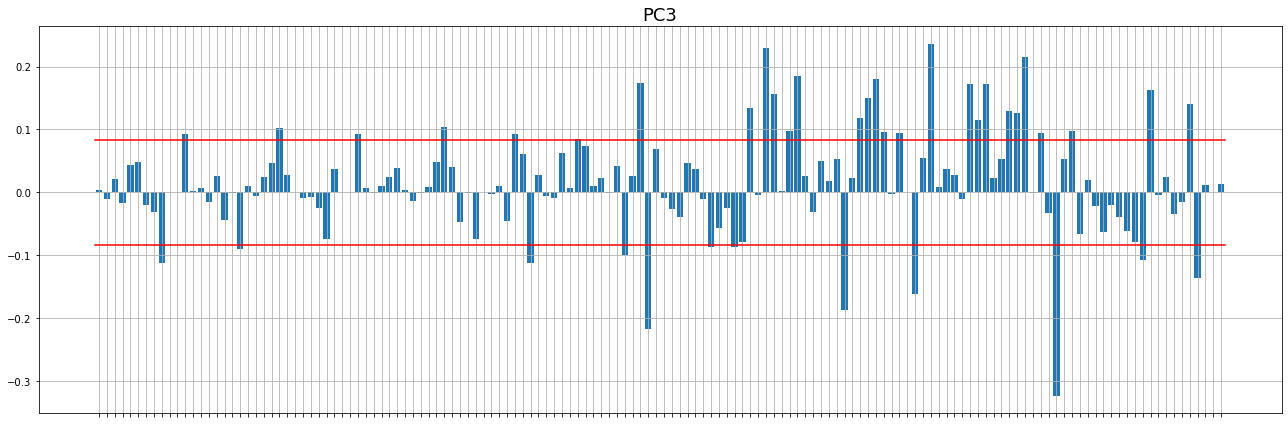


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder - Electric', 'Engine cylinder - Two cylinder boxer', 'Engine stroke - Electric', 'Gearbox - 4-speed', 'Gearbox - Not Given/Unknown', 'Fuel control - Overhead Valves (OHV)', 'Cooling system - Air', 'Fuel system - not given/unknown', 'Front brakes -  abs', 'Front brakes -  double disc', 'Front brakes -  floating discs', 'Front brakes -  four-piston calipers', 'Front brakes - expanding brake', 'Front brakes - expanding brake (drum brake)', 'Front brakes - floating discs', 'Front brakes - four-piston calipers', 'Front brakes - not given/unknown', 'Rear brakes -  abs', 'Rear brakes -  single disc', 'Rear brakes -  single-piston caliper', 'Rear brakes -  two-piston calipers', 'Rear brakes - expanding brake', 'Rear brakes - expanding brake (drum brake)', 'Rear brakes - floating disc', 'Rear brakes - not given/unknown', 'Rear brakes - two-piston calipers', 'Front tire - other', 'Rear suspension - 

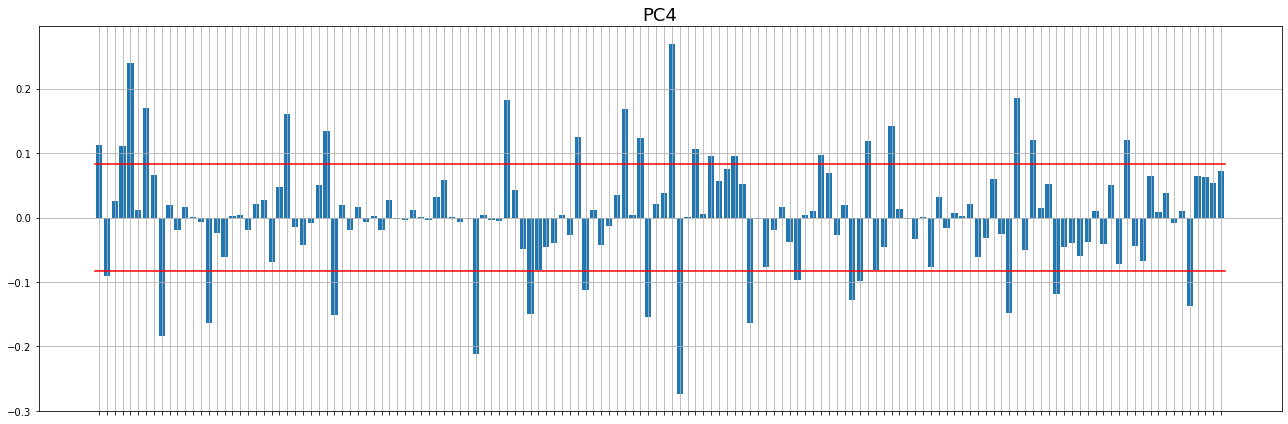


****************** PC4 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Displacement (ccm)', 'Bore (mm)', 'Stroke (mm)', 'Dry weight (kg)', 'Engine cylinder - V2', 'Engine stroke -  four-stroke', 'Gearbox - Automatic', 'Fuel control - Overhead Valves (OHV)', 'Fuel control - Single Overhead Cams (SOHC)', 'Cooling system - Air', 'Transmission type - Belt', 'Transmission type - Shaft drive', 'Fuel system -  injection', 'Fuel system - efi', 'Front brakes -  single disc', 'Front brakes - expanding brake (drum brake)', 'Front brakes - hydraulic', 'Rear brakes - expanding brake (drum brake)', 'Rear brakes - hydraulic', 'Front tire - 25/8-12']

HIGH-VALUED NEGATIVE COMPONENTS: ['Power (hp)', 'Seat height (mm)', 'Engine cylinder - In-line four', 'Engine stroke -  two-stroke', 'Gearbox - 6-speed', 'Fuel control - Double Overhead Cams/Twin Cam (DOHC)', 'Fuel control - Port control', 'Cooling system - Liquid', 'Transmission type - Chain', 'Fuel system - not given/unknown', 'Front brakes 

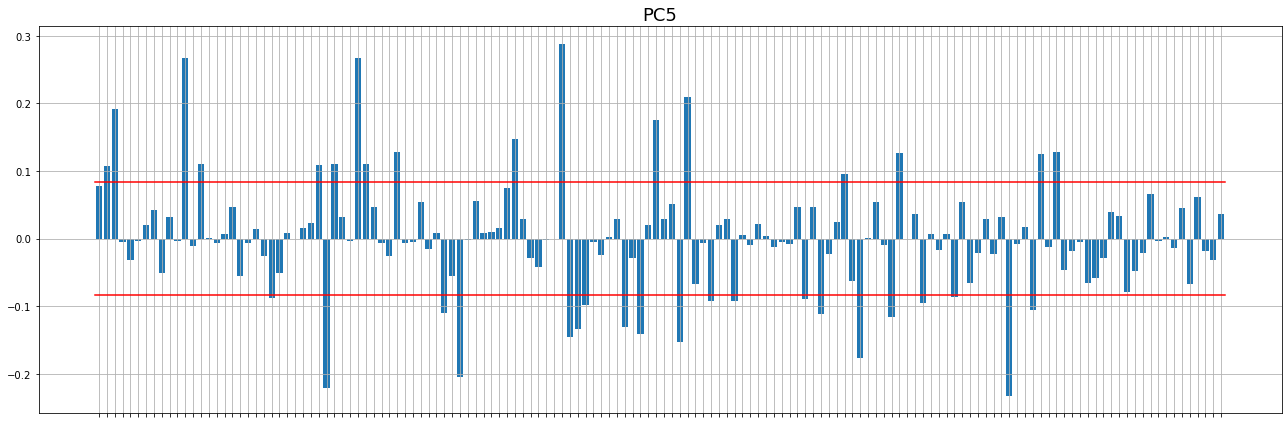


****************** PC5 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Power (hp)', 'Torque (Nm)', 'Engine cylinder - Electric', 'Engine cylinder - Gas turbine', 'Engine cylinder - V8', 'Engine stroke -  two-stroke', 'Engine stroke - Electric', 'Engine stroke - Gas turbine', 'Gearbox - 1-speed', 'Gearbox - Not Given/Unknown', 'Fuel control - Not Given/Unknown', 'Cooling system - Not Given/Unknown', 'Transmission type - Not Given/Unknown', 'Front brakes - double disc', 'Front brakes - not given/unknown', 'Rear brakes - not given/unknown', 'Rear brakes - single disc']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder - Twin', 'Engine stroke -  four-stroke', 'Gearbox - 4-speed', 'Gearbox - 5-speed', 'Fuel control - Overhead Cams (OHC)', 'Fuel control - Overhead Valves (OHV)', 'Fuel control - Port control', 'Fuel control - Single Overhead Cams (SOHC)', 'Cooling system - Air', 'Transmission type - Chain', 'Fuel system -  injection', 'Fuel system - efi', 'Front brakes -  hydraul

In [28]:
# Define the value of epsilon (ε) for the threshold
eps = np.sqrt(1 / pca_std.n_features_)

# Iterate over the principal components
for ii in range(m_std):
    # Create a new figure for each principal component
    plt.figure(figsize=(18, 6))
    
    # Create a bar plot of the component values
    plt.bar(np.arange(pca_std.n_features_), pca_std.components_[ii, :])
    
    # Plot red lines to indicate the threshold values [-ε, +ε]
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [-eps, -eps], 'red')
    
    # Configure x-axis labels and ticks
    plt.xticks(ticks=np.arange(pca_std.n_features_), labels=[], rotation=75)
    
    # Set the title of the plot as the principal component index
    plt.title(f'PC{ii + 1}', fontsize=18)
    plt.rc('xtick', labelsize=20)
    
    # Add grid lines and adjust layout
    plt.grid()
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    # Identify features contributing beyond the threshold for this principal component
    ind_great_pos_PCii = np.argwhere(pca_std.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_std.components_[ii, :] <= -eps).flatten()
    
    # Get the corresponding feature names
    great_pos_PCii = [Xworkdf_std.columns[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [Xworkdf_std.columns[i] for i in ind_great_neg_PCii]
    
    # Print the results for this principal component
    print('')
    print(f'****************** PC{ii + 1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')


**-Pc1: 'Performance'**

Among the main high-value positive  of the first principal component there are same words like 'Displacement ', 'Power ', 'Bore', 'Front brakes - double disc' all these features collectively contribute to an increased power output in terms of performance and brakes. Also   the highest values of the negative principale component 'Displacement ' and 'Dry weight' weight influences the vehicle's performance. 

**-Pc2: 'Single_Cylinder(+) VS Displacement(-)'**
The highest value for the second positive principla component is 'Engine cylinder - Single cylinder' that describe a  vehicle that  is equipped with an engine that has a single combustion cylinder. This type of engine is often used in lightweight motorcycles and vehicles with lower performance. While the highest value for the second negative principla component is 'Displacement (ccm)' that also describe che cylinder but no main features have been attributes.

**-Pc3: 'Stability(+) VS Instability(-)'**

The third positive components is caracterized by 'Front brakes -  abs', 'Rear brakes -  abs', 'Rear brakes - floating disc' that emphasizes advanced braking and stability through ABS and floating rear discs while the highest negative value of the principla component is  'Rear brakes - single disc' that  still provides a good braking capacity but might be less effective during intense braking compared to multiple discs or floating discs.

**Pc4: 'Belt(+) VS Chain(-)'**

The two highest values for the fourth positive and negative pricipal component are respectively 'Transmission type - Belt' and 'Transmission type - Chain'. In a belt transmission, there are no fixed gears as in a traditional transmission. Instead, the transmission constantly varies the transmission ratio through a belt or chain. This can contribute to smoother driving and better fuel efficiency. While the chain transmission, which connects the engine to the wheels through a chain. This system offers high transmission efficiency and a direct connection between the engine and the wheels.

**-Pc5: 'Electric(+) VS Twin(-)'**

The two highest values for the fourth positive and negative pricipal component are respectively 'Engine cylinder - Electric' and 'Engine cylinder - Twin'. The vehicle with 'Engine cylinder - Electric' uses an electric motor, which differs from traditional combustion-powered engines. Electric motors are powered by electric energy and can offer a more environmentally friendly and efficient alternative. While 'Engine cylinder - Twin'  indicates that the engine has two cylinders arranged in a parallel configuration. "Gemello" often refers to a twin-cylinder engine, which can offer a good balance between performance and efficiency.

For each PC in the Xworkdf_mm dataset,  the name of the features with greatest contribute w.r.t. to the threshold  𝜖=√1/𝑛
  where 𝑛
  is the number of features are preanted.

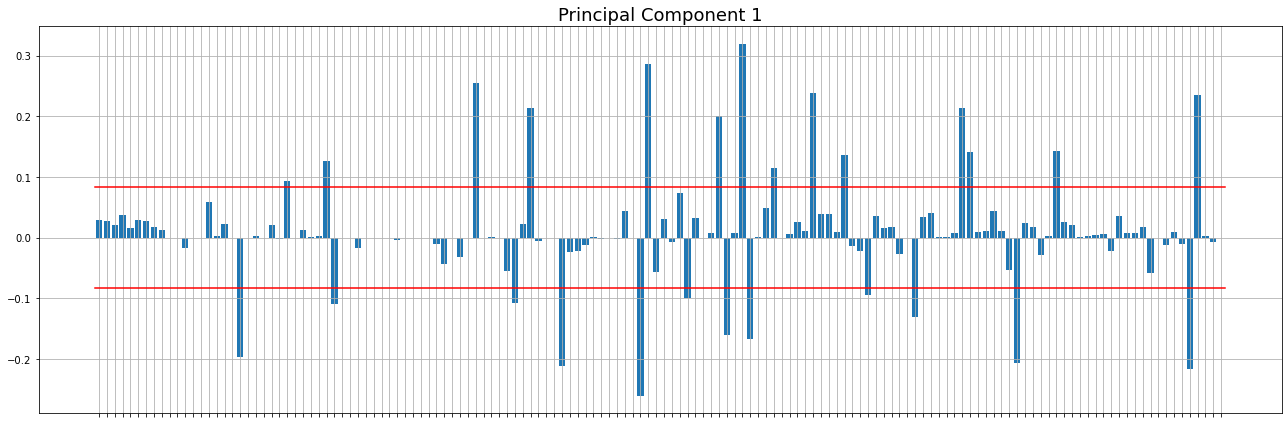


****************** Principal Component 1 **********************
 High-value Positive Features: ['Engine cylinder - V2', 'Engine stroke -  four-stroke', 'Gearbox - 6-speed', 'Fuel control - Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system - Liquid', 'Fuel system -  other', 'Fuel system - injection', 'Front brakes -  double disc', 'Front brakes -  other', 'Front brakes - double disc', 'Rear brakes -  other', 'Rear brakes -  single disc', 'Rear brakes - single disc', 'Rear suspension - other']

 High-value Negative Features: ['Engine cylinder - Single cylinder', 'Engine stroke -  two-stroke', 'Gearbox - Not Given/Unknown', 'Fuel control - Not Given/Unknown', 'Cooling system - Air', 'Transmission type - Not Given/Unknown', 'Fuel system - carburettor', 'Fuel system - not given/unknown', 'Front brakes - expanding brake (drum brake)', 'Front brakes - single disc', 'Rear brakes - expanding brake (drum brake)', 'Rear suspension - not given/unknown']
**************************************

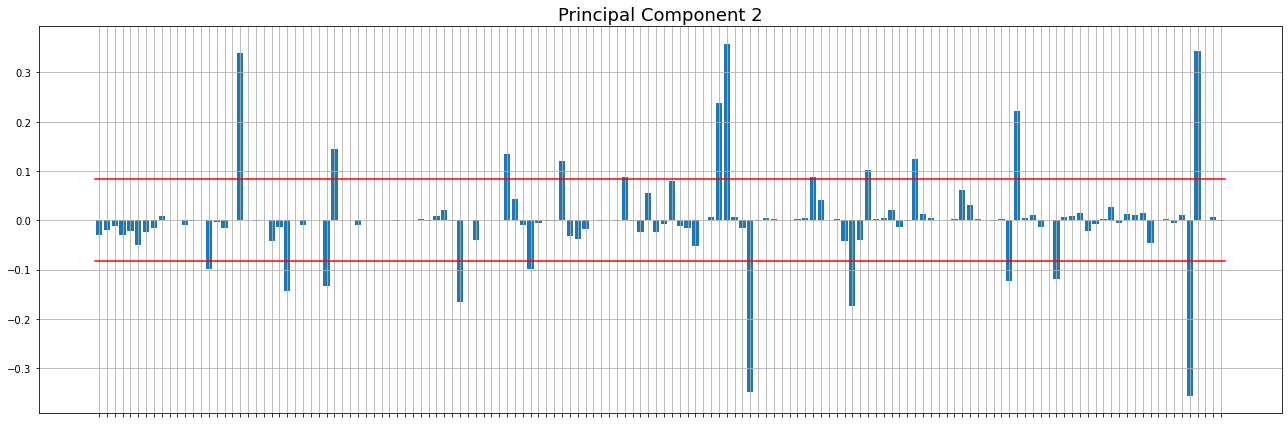


****************** Principal Component 2 **********************
 High-value Positive Features: ['Engine cylinder - Single cylinder', 'Engine stroke -  two-stroke', 'Gearbox - Automatic', 'Fuel control - Not Given/Unknown', 'Fuel control - Single Overhead Cams (SOHC)', 'Fuel system -  other', 'Fuel system - carburettor', 'Front brakes -  other', 'Front brakes - expanding brake (drum brake)', 'Front brakes - single disc', 'Rear brakes - expanding brake (drum brake)', 'Rear suspension - other']

 High-value Negative Features: ['Engine cylinder - In-line four', 'Engine cylinder - V2', 'Engine stroke -  four-stroke', 'Gearbox - 5-speed', 'Fuel control - Double Overhead Cams/Twin Cam (DOHC)', 'Fuel system - not given/unknown', 'Front brakes - dual disc', 'Rear brakes - expanding brake', 'Rear brakes - single disc', 'Rear suspension - not given/unknown']
*********************************************



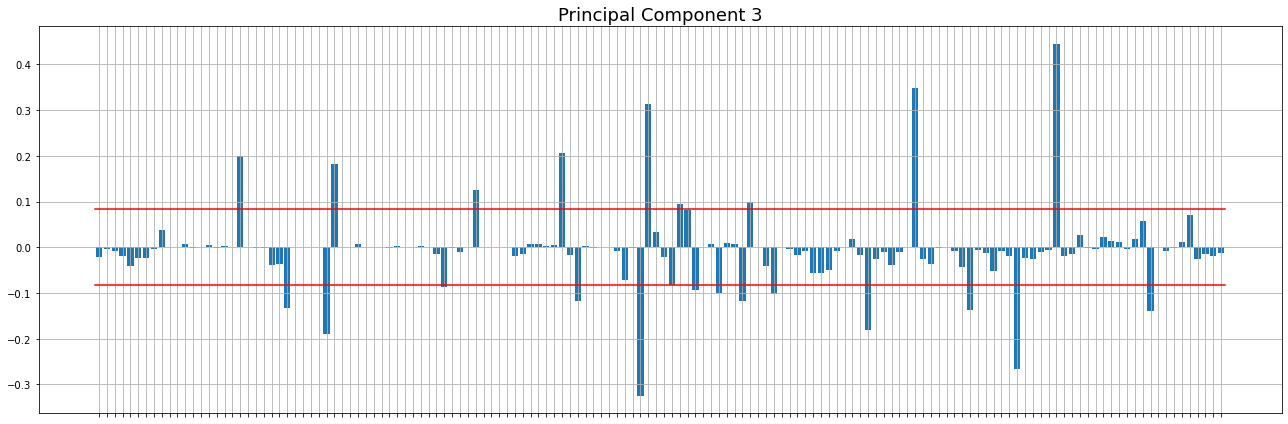


****************** Principal Component 3 **********************
 High-value Positive Features: ['Engine cylinder - Single cylinder', 'Engine stroke -  two-stroke', 'Gearbox - 6-speed', 'Fuel control - Not Given/Unknown', 'Cooling system - Liquid', 'Transmission type - Chain', 'Fuel system - not given/unknown', 'Front brakes - single disc', 'Rear brakes - single disc']

 High-value Negative Features: ['Engine cylinder - V2', 'Engine stroke -  four-stroke', 'Gearbox - 4-speed', 'Fuel control - Overhead Valves (OHV)', 'Cooling system - Air', 'Transmission type - Shaft drive', 'Fuel system -  other', 'Fuel system - injection', 'Front brakes -  double disc', 'Front brakes - expanding brake (drum brake)', 'Rear brakes -  single disc', 'Rear brakes - expanding brake (drum brake)', 'Front tire - other']
*********************************************



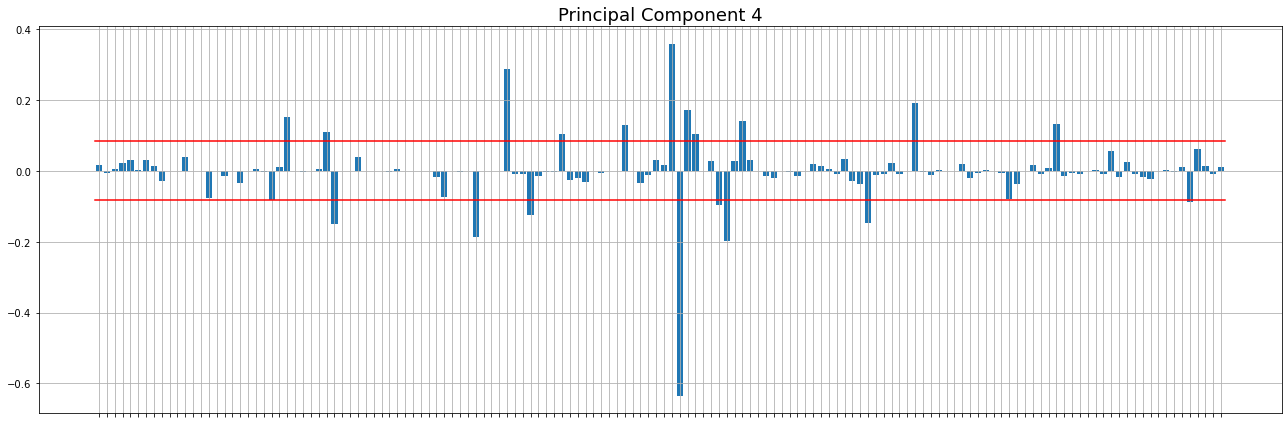


****************** Principal Component 4 **********************
 High-value Positive Features: ['Engine cylinder - V2', 'Engine stroke -  four-stroke', 'Gearbox - Automatic', 'Fuel control - Not Given/Unknown', 'Fuel control - Single Overhead Cams (SOHC)', 'Transmission type - Belt', 'Transmission type - Not Given/Unknown', 'Transmission type - Shaft drive', 'Fuel system - injection', 'Front brakes - single disc', 'Rear brakes - single disc']

 High-value Negative Features: ['Engine stroke -  two-stroke', 'Gearbox - 6-speed', 'Fuel control - Double Overhead Cams/Twin Cam (DOHC)', 'Transmission type - Chain', 'Fuel system -  other', 'Fuel system - carburettor', 'Front brakes - expanding brake (drum brake)', 'Rear suspension - not given/unknown']
*********************************************



In [38]:
# Calculation of epsilon (ε) value for threshold
epsilon = np.sqrt(1 / pca_mm.n_features_)

# FOR loop to iterate through principal components
for idx in range(m_mm):
    # Create a new figure for each principal component
    plt.figure(figsize=(18, 6))
    
    # Create a histogram of principal components
    plt.bar(np.arange(pca_mm.n_features_), pca_mm.components_[idx, :])
    
    # Plot red lines to indicate threshold values (ε)
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [epsilon, epsilon], 'red')
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [-epsilon, -epsilon], 'red')
    
    # Configure x-axis labels and ticks for readability
    plt.xticks(ticks=np.arange(pca_mm.n_features_), labels=[], rotation=75)
    
    # Set the title of the plot with the index of the principal component
    plt.title(f'Principal Component {idx + 1}', fontsize=18)
    plt.rc('xtick', labelsize=20)
    
    # Add gridlines for clarity
    plt.grid()
    
    # Optimize layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    # Identify features with contributions beyond the threshold for this principal component
    positive_contributions = \
    np.argwhere(pca_mm.components_[idx, :] >= epsilon).flatten()
    negative_contributions =\
    np.argwhere(pca_mm.components_[idx, :] <= -epsilon).flatten()
    
    # Extract names of corresponding features
    positive_features = [Xworkdf_mm.columns[i] for i in positive_contributions]
    negative_features = [Xworkdf_mm.columns[i] for i in negative_contributions]
    
    # Print results for this principal component
    print('')
    print(f'****************** Principal Component {idx+1} **********************')
    print(f' High-value Positive Features: {positive_features}')
    print('')
    print(f' High-value Negative Features: {negative_features}')
    print('*********************************************')
    print('')


**-Pc1:  'Combustion efficiency'**

The first positive principal components is describe by 'Fuel system - Injection' and  'Gearbox - 6-speed' which improves combustion efficiency compared to traditional fuel delivery systems. Also the negative principl components is describe by 'Fuel control - Double Overhead Cams/Twin Cam (DOHC)', this type of valve control system can influence the opening and closing of the valves more precisely, enhancing combustion efficiency.

**-Pc2:  'Single_cylinder_Carburettor(+) VS Not_Given(-)'**

The words like 'Engine cylinder - Single cylinder' and 'Fuel system - carburettor'  describes a vehicle in which the engine has a single combustion cylinder. Single-cylinder engines are often used in lightweight motorcycles and small motorized vehicles. The fuel system uses a carburetor to mix the fuel and air before they enter the engine. While among the negative one there are
'Fuel system - not given/unknown' and  'Rear suspension - not given/unknown, in both cases, the specifications have not been detailed or are unknown, so it is not possible to provide further details about the specific nature of these elements in the vehicle.

**-Pc3:  'Single_disc(+) VS Expanding(-)'**

The third principal component is described by 'Rear brakes - single disc' and 'Front brakes - single disc' both  rear and front brakes of the vehicle use a single disc to brake. This brake disc is bitten by the brake pads to generate the necessary friction for reducing the vehicle's speed. While the highest negative ptincipal componets is 'Rear brakes - expanding brake (drum brake)'The rear brakes of the vehicle use a drum brake system, also known as an expanding brake. This type of brake employs brake shoes that expand inside a rotating drum to generate friction and reduce the vehicle's speed. 


**-Pc4: 'Confrot(+) VS Uncomfortable(-)'**

The presence of 'Gearbox - Automatic' and 'Transmission type - Belt' among the fourth positive principal indicates a focus on driver comfort, smooth driving, and fuel efficiency. These components contribute to making the driving experience more enjoyable and can be suitable for urban and lightweight vehicles. While the negative one is describe by 'Transmission type - Chain'  that are more uncortable than 'Transmission type - Belt' because it require more maintenance compared to second one. Chains may require periodic lubrication and need to be regularly checked and tensioned to prevent wear and loss of efficiency. Additionally, chains can create slight operational noise and demand greater attention to keep them in good condition. 

# score graph

In [39]:
pc_std_names =[ 'Performance',
                'Single_Cylinder(+) VS Displacement(-)',
                'Stability(+) VS Instability(-)',
                'Belt(+) VS Chain(-)',
                'Electric(+) VS Twin(-)']

pc_mm_names =['Combustion efficiency', 
              'Single_cylinder_Carburettor(+) VS NoGiven(-)',
              'Single_disc(+) VS Expanding(-)',
              'Confrot(+) VS Uncomfortable(-)']

The decision was made to generate three score graphs (as opposed to five): specifically, 'Brand,' 'Category,' and 'Model' were selected. The inclusion of the 'Year' label was deemed less significant for the analysis, while the 'Rating' feature had numerous missing values, leading to the decision to exclude it from consideration.

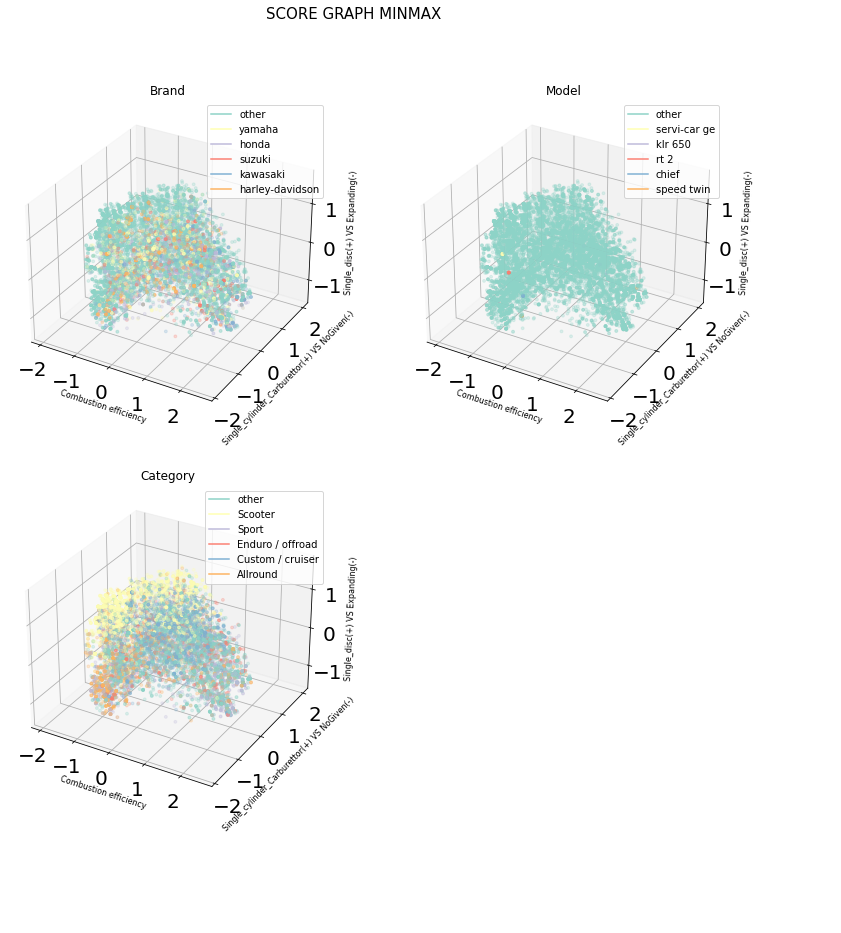

In [40]:
# Set the number of standard deviations for outliers
l_std = 3
# Set the number of min-max standard deviations for outliers
l_mm = 3

# Transform data using PCA
Y_std = pca_std.transform(Xworkdf_std)
Y_mm = pca_mm.transform(Xworkdf_mm)

# Save the colors of Set3 colormap
Set3 = cm.Set3.colors

# Create a figure with subplots
fig = plt.figure(figsize=(13, 13))
fig.suptitle('SCORE GRAPH MINMAX', fontsize=15)
meaningful_labels = ['Brand', 'Model', 'Category']
fig.text(1, 0, "    ")

# Create three 3D subplots
fig_1 = fig.add_subplot(221, projection='3d')
fig_2 = fig.add_subplot(222, projection='3d')
fig_3 = fig.add_subplot(223, projection='3d')
fig_mm = [fig_1, fig_2, fig_3]

# Loop through each subplot for each meaningful label
for i in range(3):
    current_label = meaningful_labels[i]
    occurence = workdf[current_label].value_counts() 
    principal_cat = occurence.nlargest(5).index.tolist() 
    principal_cat.insert(0, 'other') 
    
    # Create a dictionary of label colors
    label_colors = {principal_cat[i]: Set3[i] for i in range(len(principal_cat))}
    color = [label_colors[j] if j in principal_cat
             else label_colors['other'] for j in workdf[current_label].values]
    
    # Create a custom legend for colors
    colors_legend = [Line2D([0], [0], color=label_colors[k]) \
                     for k in label_colors.keys()]
    
    # Create a 3D scatter plot
    fig_mm[i].scatter(Y_mm[:, 0], Y_mm[:, 2], Y_mm[:, 3], s=8, c=color, alpha=0.25)
    fig_mm[i].set_xlabel(pc_mm_names[0], fontsize=8)
    fig_mm[i].set_ylabel(pc_mm_names[1], fontsize=8)
    fig_mm[i].set_zlabel(pc_mm_names[2], fontsize=8)
    fig_mm[i].set_title(meaningful_labels[i])
    fig_mm[i].legend(colors_legend, [t for t in label_colors.keys()],\
                     loc='upper right')

# Display the plot
plt.show()


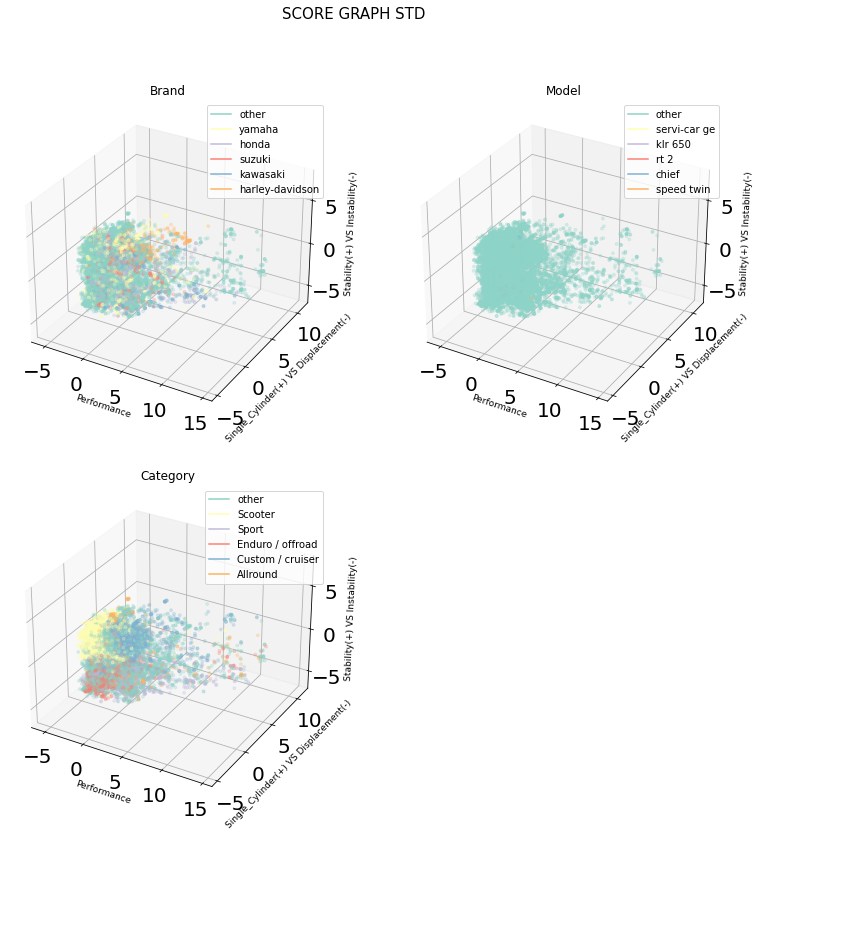

In [41]:
# Create a figure with subplots for the SCORE GRAPH STD
fig = plt.figure(figsize=(13, 13))
fig.suptitle('SCORE GRAPH STD', fontsize=15)
fig.text(1, 0, "    ")

# Create three 3D subplots for the SCORE GRAPH STD
fig_1 = fig.add_subplot(221, projection='3d')
fig_2 = fig.add_subplot(222, projection='3d')
fig_3 = fig.add_subplot(223, projection='3d')
fig_std = [fig_1, fig_2, fig_3]

# Loop through each subplot for each meaningful label
for i in range(3):
    current_label = meaningful_labels[i]
    occurence = workdf[current_label].value_counts() 
    principal_cat = occurence.nlargest(5).index.tolist() 
    principal_cat.insert(0, 'other') 
    
    # Create a dictionary of label colors
    label_colors = {principal_cat[i]: Set3[i] for i in range(len(principal_cat))}
    color = [label_colors[j] if j in principal_cat
             else label_colors['other'] for j in workdf[current_label].values]
    
    # Create a custom legend for colors
    colors_legend = [Line2D([0], [0], color=label_colors[k]) \
                     for k in label_colors.keys()]
    
    # Create a 3D scatter plot for the SCORE GRAPH STD
    fig_std[i].scatter(Y_std[:, 0], Y_std[:, 2], Y_std[:, 3], s=8, c=color, alpha=0.25)
    fig_std[i].set_xlabel(pc_std_names[0], fontsize=9)
    fig_std[i].set_ylabel(pc_std_names[1], fontsize=9)
    fig_std[i].set_zlabel(pc_std_names[2], fontsize=9)
    fig_std[i].set_title(meaningful_labels[i])
    fig_std[i].legend(colors_legend, [t for t in label_colors.keys()],\
                     loc='upper right')

# Display the  plot
plt.show()


The granularity of the feature prevents any extraction of information about individual motorcycle models.

Regarding the "Brand," it's widely recognized that almost every brand produces various types of vehicles, making it challenging to predict the brand solely through an analysis driven by characteristics and specifics. 

The "Category" label differentiates the models most effectively. Each distinct category appears to belong to a specific region within the plotted 3D space. This differentiation arises from the unique requirements of various types of motors. For example, a "scooter" doesn't require the same level of gearbox versatility as an "enduro."

Regarding the 'Model' feature, substantial insights couldn't be drawn due to the limited number of records for each model type. Consequently, the 'other' label dominates over the five most prevalent models.

# Kmeans

The k-Means algorithm was applied to the two dataframes and the optimal value of k  was chosen using the silhouette coefficient.

In [42]:
# INITIALIZE SOME LISTS TO STORE THE TEMPORARY RESULTS AND, THEN, MAKE COMPARISONS
km_list_std = []
silcoeff_list_std = []
k_list_std = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_std)):
    km_list_std.append(KMeans(n_clusters=k_list_std[i], n_init=3, random_state=rs))
    km_std = km_list_std[i]
    km_std.fit(Y_std)
    silcoeff_list_std.append(silhouette_score(Y_std, km_std.labels_))
# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_std = np.argmax(silcoeff_list_std)
k_std = k_list_std[i_best_std]
km_std = km_list_std[i_best_std]
sil_coeff_std = np.max(silcoeff_list_std)
# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE STD: {np.max(silcoeff_list_std)} --> k = {k_std}')
print('**************************************************************')



****************** RESULTS OF THE SEARCH... ******************
BEST SILHOUETTE SCORE STD: 0.28551064879176813 --> k = 4
**************************************************************


In [43]:
# INITIALIZE SOME LISTS TO STORE THE TEMPORARY RESULTS AND, THEN, MAKE COMPARISONS
km_list_mm = []
silcoeff_list_mm = []
k_list_mm = list(range(3, 11))
# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_mm)):
    km_list_mm.append(KMeans(n_clusters=k_list_mm[i], n_init=3, random_state=rs))
    km_mm = km_list_mm[i]
    km_mm.fit(Y_mm)
    silcoeff_list_mm.append(silhouette_score(Y_mm, km_mm.labels_))
# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm = np.argmax(silcoeff_list_mm)
k_mm = k_list_mm[i_best_mm]
km_mm = km_list_mm[i_best_mm]
sil_coeff_mm = np.max(silcoeff_list_mm)

# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE for MINMAX: {np.max(silcoeff_list_mm)} --> k = {k_mm}')
print('**************************************************************')



****************** RESULTS OF THE SEARCH... ******************
BEST SILHOUETTE SCORE for MINMAX: 0.315420500286903 --> k = 4
**************************************************************


# Clusters and Centroid Interpretation and Visualization

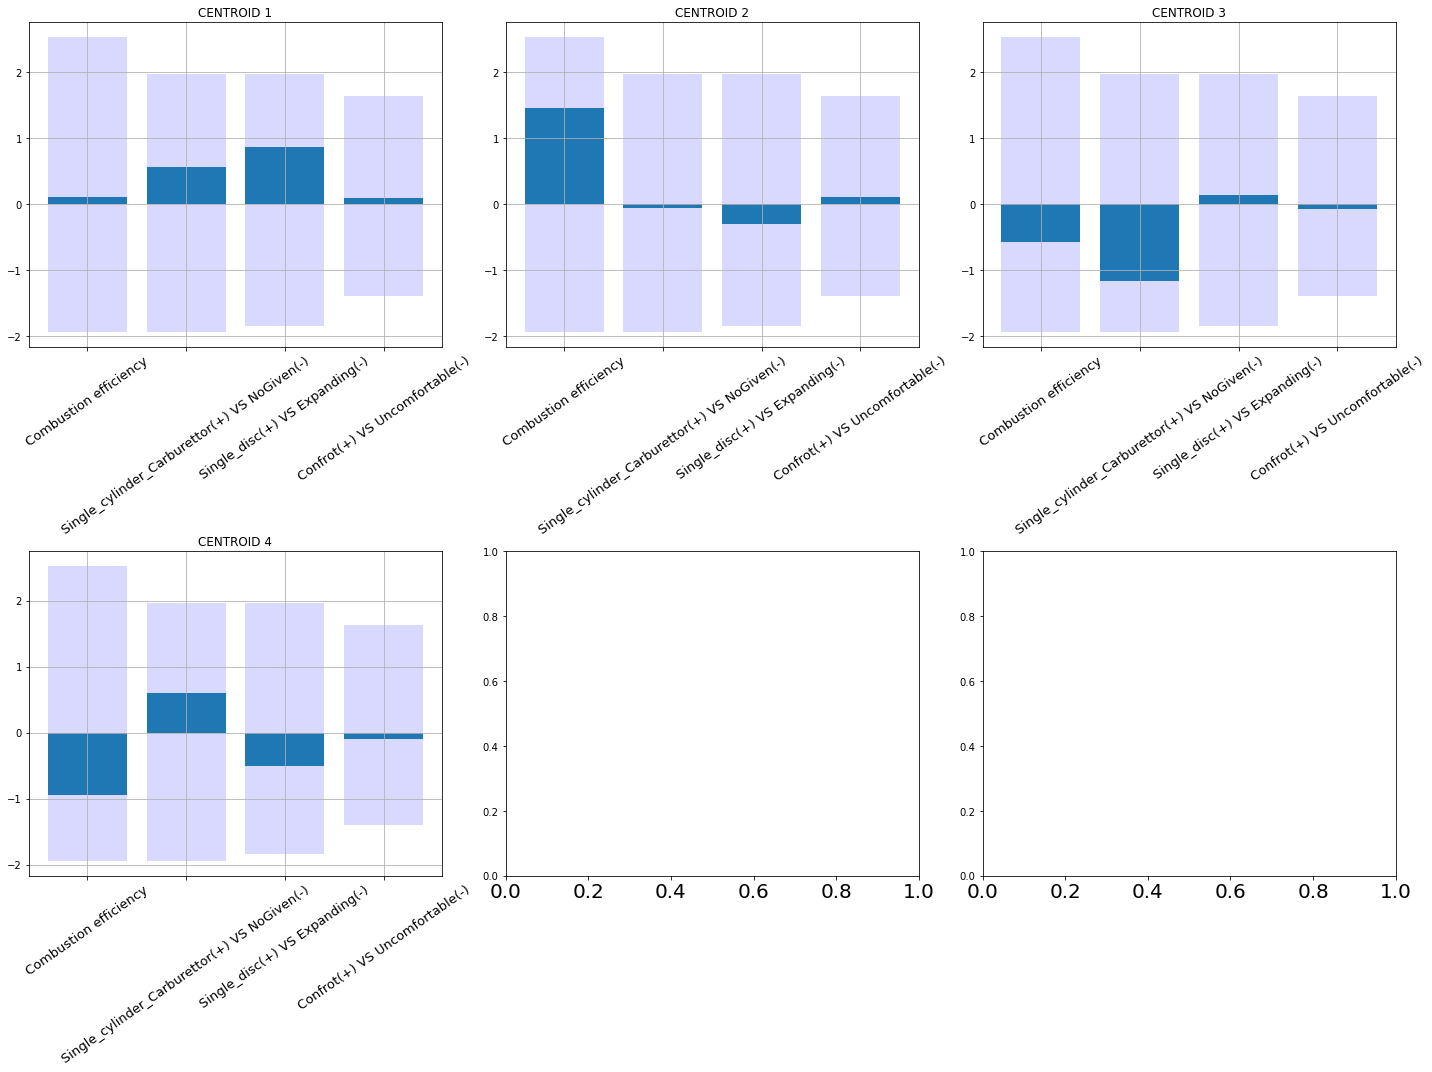

In [45]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y_mm = Y_mm.max(axis=0) 
mins_y_mm = Y_mm.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids_mm, ax_centroids_mm = plt.subplots(2, 3, figsize=(20, 15))
for ii in range(k_mm):
    ir = ii // 3
    ic = ii % 3
    ax_centroids_mm[ir, ic].bar(np.arange\
                            (km_mm.cluster_centers_.shape[1]),maxs_y_mm,\
                                color='blue', alpha=0.15)
    ax_centroids_mm[ir, ic].bar(np.arange\
                            (km_mm.cluster_centers_.shape[1]),mins_y_mm,\
                                color='blue', alpha=0.15)
    ax_centroids_mm[ir, ic].bar(np.arange\
                            (km_mm.cluster_centers_.shape[1]),\
                                km_mm.cluster_centers_[ii, :])
    ax_centroids_mm[ir, ic].set_xticks\
    (ticks=np.arange(km_mm.cluster_centers_.shape[1]))
    ax_centroids_mm[ir, ic].set_xticklabels\
    (labels=pc_mm_names, fontsize = 13, rotation=35)
    ax_centroids_mm[ir, ic].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids_mm[ir, ic].set_title(f'CENTROID {ii+1}')

**CENTROID 1:** the first centroid describe vehicle  whit single cylinder and the fuel system uses a carburetor that, while the  system of breaks use an expanding brake.

**CENTROID 2:** in the second cluster, there are specialized vehicles focused on enhancing combustion efficiency.

**CENTROID 3:** The third centroid represents non-specialized vehicles in enhancing combustion efficiency, and their specifications regarding displacement and fuel are not specified.

**CENTROID 4:** In the fourth cluster, there are vehicles with relatively inefficient combustion, characterized by a single displacement, using fuel, and equipped with an expanding brake system.

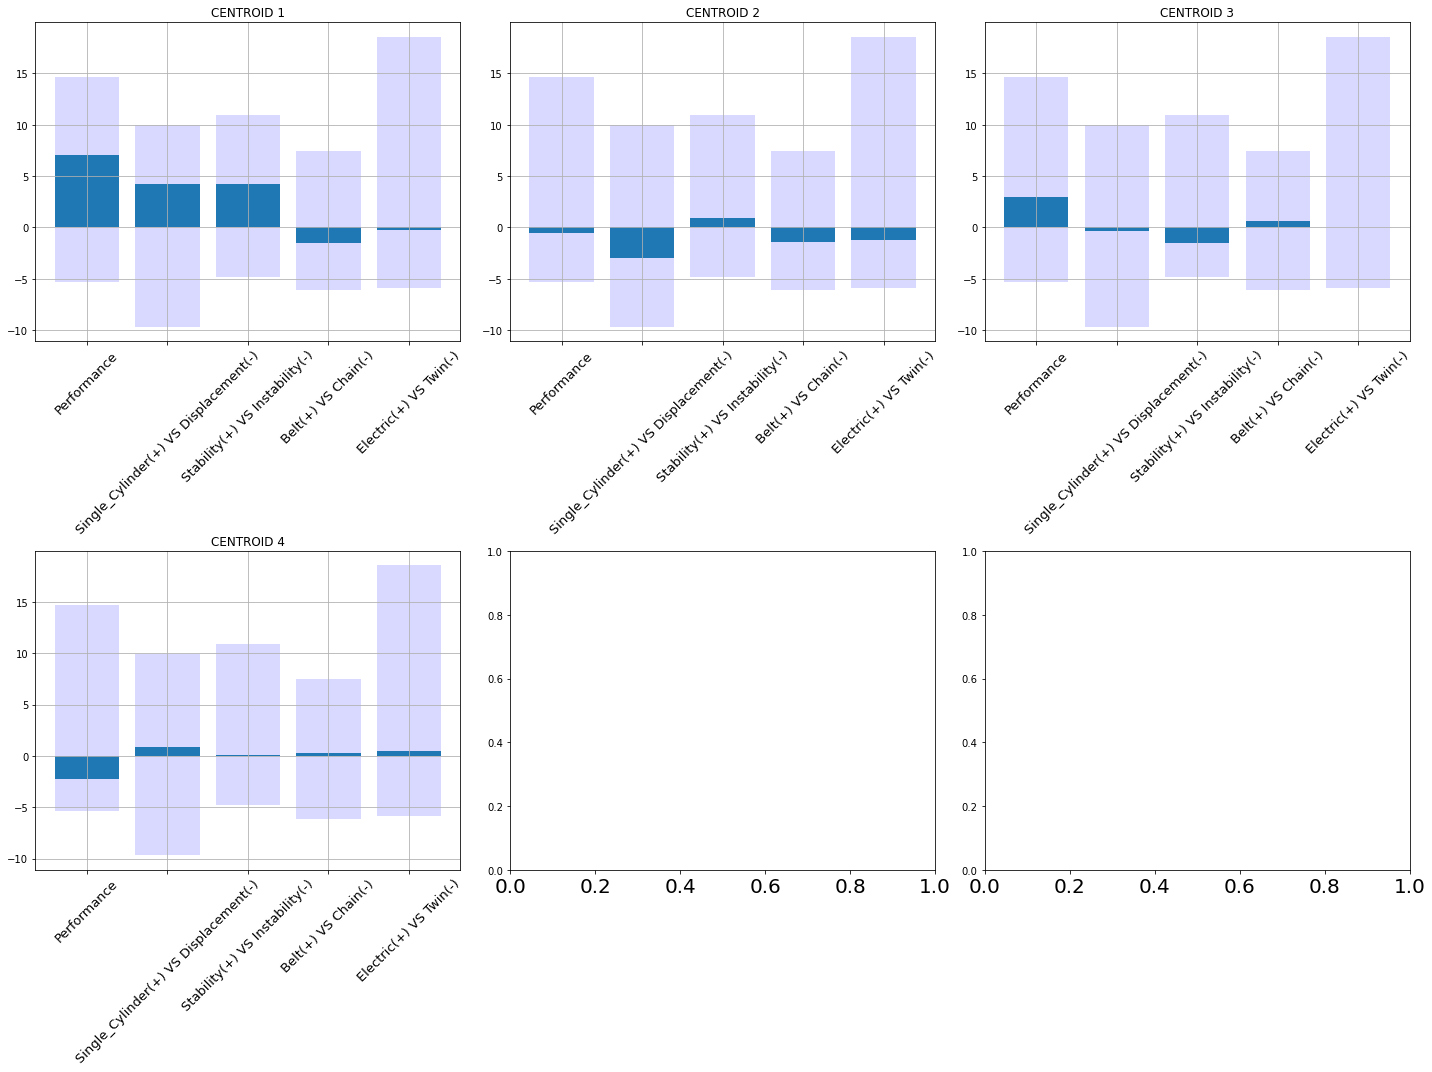

In [46]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y_std = Y_std.max(axis=0) 
mins_y_std = Y_std.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(2,3, figsize=(20, 15))
for ii in range(k_std):
    ir = ii // 3
    ic = ii % 3
    ax_centroids[ir, ic].bar(np.arange\
                             (km_std.cluster_centers_.shape[1]), maxs_y_std,\
                             color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange\
                             (km_std.cluster_centers_.shape[1]), mins_y_std,\
                             color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange\
                             (km_std.cluster_centers_.shape[1]),\
                             km_std.cluster_centers_[ii, :])
    ax_centroids[ir, ic].set_xticks\
    (ticks=np.arange(km_std.cluster_centers_.shape[1]))
    ax_centroids[ir, ic].set_xticklabels\
    (labels=pc_std_names,fontsize = 13, rotation=45)
    ax_centroids[ir, ic].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ir, ic].set_title(f'CENTROID {ii+1}')
   


**CENTROID 1:** the first cluster describes vehicles that have high-performance capabilities in terms of performance. These vehicles feature a single displacement and exhibit great stability.

**CENTROID 2:** in the second cluster, there are vehicles whose displacement is not specified, characterized by a chain-type transmission system.

**CENTROID 3:**  the third centroid describe  vehicles with reasonably high performance, but the type of displacement is not specified.

**CENTROID 4:**  the last centroide descrive vehicles poor perfomace.

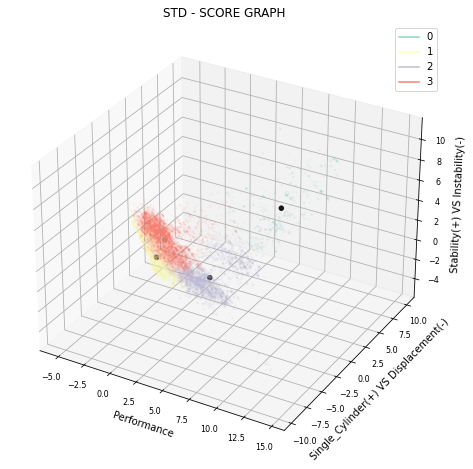

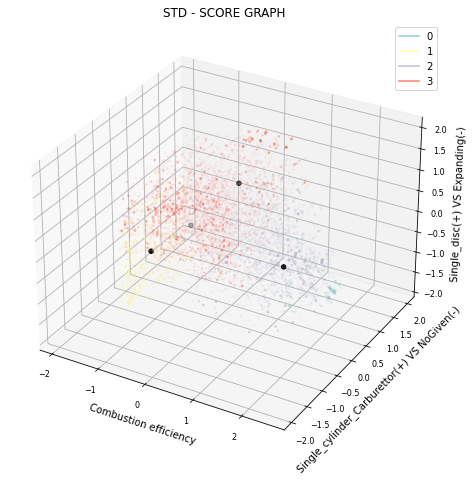

In [47]:

# EVALUATING COLORS
colorset = cm.Set3.colors
c_colors = {i: colorset[i] for i in range(k_std)}
cluster_colors_std = [c_colors[t] for t in km_std.labels_]
# legend
colors_legend = [Line2D([0], [0], color = c_colors[k]) for k in c_colors.keys()]
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS
sg_3d_km_std = plt.figure(figsize=(8, 8))
ax_sg_3d_km_std = sg_3d_km_std.add_subplot(111, projection='3d')
ax_sg_3d_km_std.scatter\
(Y_std[:, 0], Y_std[:, 1], Y_std[:, 2], s=2,\
 c = cluster_colors_std, alpha=0.05)
ax_sg_3d_km_std.scatter\
(km_std.cluster_centers_[:, 0], km_std.cluster_centers_[:, 1],\
 km_std.cluster_centers_[:, 2], c='black')
plt.title('STD - SCORE GRAPH')
ax_sg_3d_km_std.set_xlabel(pc_std_names[0])
ax_sg_3d_km_std.set_ylabel(pc_std_names[1])
ax_sg_3d_km_std.set_zlabel(pc_std_names[2])
ax_sg_3d_km_std.legend(colors_legend, [k for k in c_colors.keys()])


ax_sg_3d_km_std.tick_params(axis='both', which='major', labelsize=8)  # Adjust font size for ticks



c_colors = {i: colorset[i] for i in range(k_mm)}
cluster_colors_mm = [c_colors[t] for t in km_mm.labels_]
# legend
colors_legend = [Line2D([0], [0], color = c_colors[k]) for k in c_colors.keys()]
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS
sg_3d_km_mm = plt.figure(figsize=(8, 8))
ax_sg_3d_km_mm = sg_3d_km_mm.add_subplot(111, projection='3d')
ax_sg_3d_km_mm.scatter\
(Y_mm[:, 0], Y_mm[:, 1], Y_mm[:, 2], s=2, c = cluster_colors_std, alpha=0.05)
ax_sg_3d_km_mm.scatter\
(km_mm.cluster_centers_[:, 0], km_mm.cluster_centers_[:, 1], \
 km_mm.cluster_centers_[:, 2], c='black')
plt.title('STD - SCORE GRAPH')
ax_sg_3d_km_mm.set_xlabel(pc_mm_names[0])
ax_sg_3d_km_mm.set_ylabel(pc_mm_names[1])
ax_sg_3d_km_mm.set_zlabel(pc_mm_names[2])
ax_sg_3d_km_mm.legend(colors_legend, [k for k in c_colors.keys()])
ax_sg_3d_km_mm.tick_params(axis='both', which='major', labelsize=8)  # Adjust font size for ticks

plt.grid()
plt.show()

# Clusters and Centroids Evaluation

For the evaluation of the clustering method K-means there are two approches used:
**Internal evaluation:** It quantifies the extent to which the clustering outcome generates clusters characterized by significant internal similarity while exhibiting minimal similarity with neighboring clusters. One of the most used interal evaluation is the **silhouette**, a cluster validity metric that evaluates the internal coherence of data within each cluster and their separation from neighboring clusters and takes values from -1 to 1. 

In this case  the best silhouette obtain for standadize data is 0.28551064879176813 


While the  the best silhouette obtain for standadize data is 0.315420500286903 


**External evaluation:** when data is categorized, the ultimate clusters are examined based on the labels assigned to the data they contain. Selecting the label 'Category', because is the one that  differentiates the models most effectively.

In [48]:
def get_cluster_percentages(data, cluster_labels, num_clusters):
    # Create a list of cluster names
    cluster_name = [f'Cluster {i}' for i in range(num_clusters)]
    # Create an empty DataFrame with cluster names as columns
    columns = pd.DataFrame(columns=cluster_name)
    # Loop through unique categories in the data
    for group in data['Category'].unique():
        # Get indices of data points belonging to the current category
        group_indices = data[data['Category'] == group].index
        # Create a Series containing cluster names
        #for data points in the current category
        cluster_series = pd.Series\
        ([f'Cluster {i}' for i in cluster_labels[group_indices]])
        # Calculate percentages of each cluster within the current category
        percentages = cluster_series.value_counts(normalize=True)
        # Concatenate the percentages Series to the columns DataFrame
        percentages.name = group
        columns = pd.concat([columns, percentages.to_frame().T])
    
    columns.fillna(0, inplace=True)
    return columns


# Get cluster percentages for min-max scaling
columns_mm = get_cluster_percentages(workdf, km_mm.labels_, k_mm)
display(columns_mm)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Prototype / concept model,0.136364,0.439394,0.363636,0.060606
ATV,0.321343,0.407674,0.033573,0.237410
Allround,0.066417,0.165575,0.176801,0.591207
Scooter,0.270985,0.073905,0.085766,0.569343
Sport,0.123265,0.335369,0.200999,0.340366
Naked bike,0.129159,0.541096,0.242661,0.087084
Custom / cruiser,0.074485,0.458796,0.331220,0.135499
Cross / motocross,0.679518,0.093976,0.120482,0.106024
"Minibike, sport",0.434783,0.065217,0.065217,0.434783
"Minibike, cross",0.333333,0.000000,0.152047,0.514620


**MM**
The partition appears to be clearer for certain categories, such as "Unspecified category" and "Classic" which are distinctly concentrated in Cluster 2. Same categorie like "Trial" or "Cross / motocross exhibit" have dominant distribution in aspecific cluster, both in Cluster 1. Categories like "Allround," "Scooter," "Sport," "Naked bike," "Custom / cruiser," and others are distributed across multiple clusters, suggesting overlaps or variations in the data within these categories.

In [49]:
# Get cluster percentages for standardization
columns_std = get_cluster_percentages(workdf, km_std.labels_, k_std)
display(columns_std)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Prototype / concept model,0.075758,0.166667,0.424242,0.333333
ATV,0.057554,0.011990,0.570743,0.359712
Allround,0.041160,0.152479,0.136576,0.669785
Scooter,0.011405,0.004562,0.073449,0.910584
Sport,0.081066,0.159356,0.285397,0.474181
Naked bike,0.103718,0.212329,0.499022,0.184932
Custom / cruiser,0.039620,0.231379,0.565769,0.163233
Cross / motocross,0.019277,0.074699,0.190361,0.715663
"Minibike, sport",0.000000,0.021739,0.000000,0.978261
"Minibike, cross",0.000000,0.017544,0.000000,0.982456


**STD**

Also for this case he partition doesn't seem to be equally clear for all vehicle categories. There are categories that are distinctly represented in individual clusters like "Unspecified category" is mainly in Cluster 1, "Speedway" is primarily in Cluster 1 with a bit in Cluster 3, and "Classic" is predominantly concentrated in Cluster 1, while other categories are spread across multiple clusters like "Scooter", "Allround", "Custom / cruiser", "Cross / motocross", "Enduro / offroad". In particular Cluster 3 seem to have a tendency to accommodate a variety of vehicle categories.